# Data Sampling Approaches

In this notebook we experiment with vaious data sampling approaches to improve the model's performance.

Our analysis of the data showed that the dataset had imbalanced classes. The number of examples without patronising and condescending language (PCL) is much higher than the number of examples with PCL. Models trained on imbalanced datasets may learn biased prior probabilities.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import transformers
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import pipeline, RobertaModel, AutoTokenizer, AutoModelForSequenceClassification, AdamW, DataCollatorWithPadding, get_scheduler
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

/vol/bitbucket/mwl21/nlp-venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch import cuda

device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# Load the pre-trained model
checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, truncation=True, do_lower_case=True)
pretrained_model = RobertaModel.from_pretrained(checkpoint, num_labels=2)
pretrained_model = pretrained_model.to(device)

MAX_LEN = 256
LEARNING_RATE = 1e-05

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Class for the data
class PCLData(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = data
        self.text = self.data.text
        self.targets = self.data.label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True,
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [5]:
train_params = {'batch_size': 8,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': 4,
                'shuffle': True,
                'num_workers': 0
                }

In [6]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = pretrained_model
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output
    

model = RobertaClass()
model.to(device)

RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [17]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params =  model.parameters(), lr=LEARNING_RATE)

def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct


def train(epoch, training_loader):
    tr_loss = 0; n_correct = 0; steps = 0; seen = 0
    model.train()
    for i,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        preds = model(ids, mask, token_type_ids)
        loss = loss_function(preds, targets)
        tr_loss += loss.item()
        _, pred_labels = torch.max(preds.data, dim=1)
        n_correct += calcuate_accuracy(pred_labels, targets)

        steps += 1
        seen+=targets.size(0)
        
        if i%5000==0:
            curr_loss = tr_loss/steps
            curr_acc = (n_correct*100)/seen 
            print(f"Training Loss per 5000 steps: {curr_loss}")
            print(f"Training Accuracy per 5000 steps: {curr_acc}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Total Accuracy for Epoch {epoch}: {(n_correct*100)/seen}')
    epoch_loss = tr_loss/steps
    epoch_accu = (n_correct*100)/seen
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 


def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; steps=0; seen=0
    preds_model = torch.tensor([]).to(device); targets_model = torch.tensor([]).to(device)

    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            preds = model(ids, mask, token_type_ids).squeeze()
            
            _, pred_labels = torch.max(preds.data, dim=1)
            n_correct += calcuate_accuracy(pred_labels, targets)

            steps += 1
            seen+=targets.size(0)

            preds_model = torch.cat((preds_model, pred_labels))
            targets_model = torch.cat((targets_model, targets))
            
    epoch_accu = (n_correct*100)/seen

    return epoch_accu, preds_model, targets_model

## Approach 1: oversampling

Random oversampling: a random choice of minority instances are duplicated.

In [34]:
train_df = pd.read_csv('train_dev_data/train_set.csv')
test_df = pd.read_csv('train_dev_data/dev_set.csv')
print(train_df['label'].value_counts())

X_train = train_df[['text']]  # Feature columns
y_train = train_df['label']  # Target column

# Initialize the random oversampler
ros = RandomOverSampler(random_state=42)

# Apply oversampling
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Update the dataset with the resampled values
train_df = pd.DataFrame(X_resampled, columns=X_train.columns)
train_df['label'] = y_resampled

# Verify the oversampling result
print(train_df['label'].value_counts())

label
0    7581
1     794
Name: count, dtype: int64
label
0    7581
1    7581
Name: count, dtype: int64


In [35]:
test_df = test_df[['text', 'label']]

train_dataset = PCLData(train_df, tokenizer, MAX_LEN)
test_dataset = PCLData(test_df, tokenizer, MAX_LEN)

training_loader = DataLoader(train_dataset, **train_params)
testing_loader = DataLoader(test_dataset, **test_params)

In [ ]:
EPOCHS = 2
for epoch in range(EPOCHS):
    train(epoch, training_loader)

0it [00:00, ?it/s]/vol/bitbucket/mwl21/nlp-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2690: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
1it [00:00,  6.93it/s]

Training Loss per 5000 steps: 0.3701927959918976
Training Accuracy per 5000 steps: 87.5


1896it [11:35,  2.73it/s]


Total Accuracy for Epoch 0: 92.43503495581058
Training Loss Epoch: 0.20474089447429544
Training Accuracy Epoch: 92.43503495581058


1it [00:00,  4.25it/s]

Training Loss per 5000 steps: 0.012173354625701904
Training Accuracy per 5000 steps: 100.0


1896it [11:34,  2.73it/s]


Total Accuracy for Epoch 1: 97.83669700567208
Training Loss Epoch: 0.06529420380779485
Training Accuracy Epoch: 97.83669700567208


1it [00:00,  4.20it/s]

Training Loss per 5000 steps: 0.007400239817798138
Training Accuracy per 5000 steps: 100.0


735it [04:29,  2.72it/s]


KeyboardInterrupt: 

In [36]:
acc, preds, targets = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

0it [00:00, ?it/s]/vol/bitbucket/mwl21/nlp-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2690: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
524it [00:32, 16.21it/s]

Accuracy on test data = 91.79%


Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95      1895
         1.0       0.57      0.55      0.56       199

    accuracy                           0.92      2094
   macro avg       0.76      0.75      0.76      2094
weighted avg       0.92      0.92      0.92      2094

Confusion Matrix:
[[1813   82]
 [  90  109]]


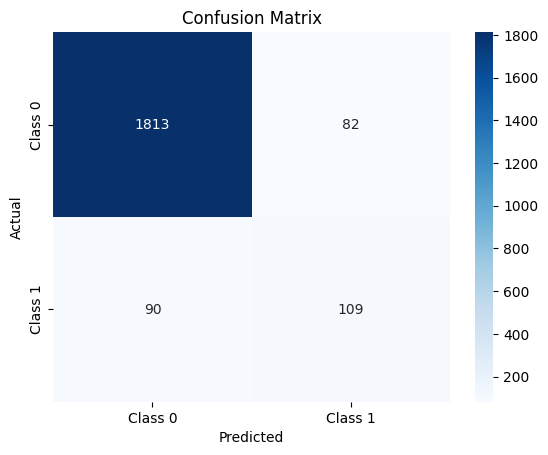

In [37]:
print("Classification Report:")
print(classification_report(targets.cpu().numpy(), preds.cpu().numpy()))

# Confusion matrix
cm = confusion_matrix(targets.cpu().numpy(), preds.cpu().numpy())
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
output_model_file = 'roberta_oversampling.bin'
output_vocab_file = './'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')

## Approach 2: undersampling

Random undersampling: a random choice of majority instances are removed from the dataset.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

X_train = train_dataset[['text']]  # Feature columns
y_train = train_dataset['label']  # Target column

# Initialize the random oversampler
rus = RandomUnderSampler(random_state=42)

# Apply oversampling
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Update the dataset with the resampled values
train_dataset = pd.DataFrame(X_resampled, columns=X_train.columns)
train_dataset['label'] = y_resampled

# Verify the oversampling result
print(train_dataset['label'].value_counts())


In [ ]:
from datasets import Dataset

test_dataset = test_dataset[['text', 'label']]

train_dataset = PCLData(train_dataset, tokenizer, MAX_LEN)
test_dataset = PCLData(test_dataset, tokenizer, MAX_LEN)

training_loader = DataLoader(train_dataset, **train_params)
testing_loader = DataLoader(test_dataset, **test_params)

In [ ]:
EPOCHS = 5
for epoch in range(EPOCHS):
    train(epoch, training_loader)

In [ ]:
acc, preds, targets = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

In [ ]:
print("Classification Report:")
print(classification_report(targets.cpu().numpy(), preds.cpu().numpy()))

# Confusion matrix
cm = confusion_matrix(targets.cpu().numpy(), preds.cpu().numpy())
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
output_model_file = 'roberta_oversampling.bin'
output_vocab_file = './'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')

## Approach 3: added synthetically generated data


In [ ]:
from imblearn.over_sampling import SMOTE

X_train = train_df['text']
y_train = train_df['label']
X_test = dev_df['text']
y_test = dev_df['label']

# Convert text to numerical representation
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Apply SMOTE to balance the training data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)